# Uncalibrated photometric stereo constrained by intrinsic reﬂectance image and shape from silhoutte

In [24]:
import cv2
import sys

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tenpy.linalg.svd_robust import svd
from RenderSurfaceMap import image_renderer

In [25]:
# read in the images from folder dataset/PhotometricStereo/PSData/cat/Objects
images = []

folder_path = Path("../Data/Dataset/")
# folder_path = Path("../../GroupWork-Private/PSData/cat/Objects/")

for img_path in folder_path.glob('*.png'):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    images.append(img)

images = np.array(images)  # shape: (n_images, width, height)

In [26]:
images.shape

(20, 640, 500)

In [27]:
n_images,width, height = images.shape
print(n_images, width, height)

P = width * height  # total number of pixels

20 640 500


In [28]:
# linearized_images = []
# for image in images:
#     linearized_image, _, _ = np.linalg.svd(image, compute_uv=True, full_matrices=False)
#     linearized_images.append(linearized_image)

# # convert to numpy array
# linearized_images = np.array(linearized_images)
# linearized_images[0].shape

## 3.2 Estimate of the Albedo

In [29]:
# compute the average image
average_image = np.mean(images, axis=0)

# apply a bilateral filter to the average image
# the default parameters from OpenCV are used: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
albedo_estimate = cv2.bilateralFilter(average_image.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# reshape the albedo estimate to width x height x (gray scale channel)
albedo_estimate = albedo_estimate.reshape((width, height, -1))
print('Albedo estimate shape:', albedo_estimate.shape)

Albedo estimate shape: (640, 500, 1)


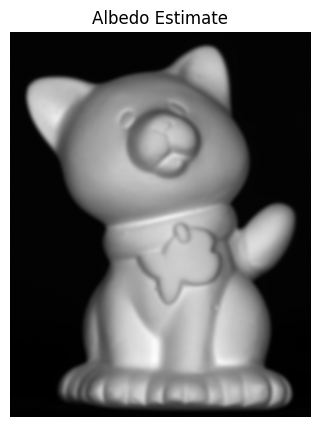

In [30]:
# visualize the albedo estimate
plt.figure(figsize=(5, 5))
plt.imshow(albedo_estimate, cmap='gray')
plt.axis('off')

# save the albedo estimate
plt.savefig("../Report/IMG/res-01-albedo.png", bbox_inches="tight", pad_inches=0)

plt.title('Albedo Estimate')
plt.show()

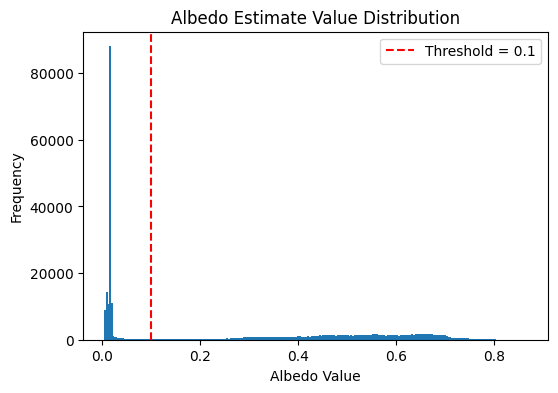

In [31]:
# define a threshold for albedo values
THRESHOLD = 0.1

# visualize the albedo estimate value distribution to define a threshold
plt.figure(figsize=(6, 4))
plt.hist(albedo_estimate.ravel(), bins=256)
plt.axvline(x=THRESHOLD, color='r', linestyle='--', label=f'Threshold = {THRESHOLD}')
plt.title('Albedo Estimate Value Distribution')
plt.xlabel('Albedo Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 3.3 Singular value decomposition

In [32]:
# compute the tresholded albedo mask, this mask is used to ignore low albedo values (pixels with a low brightness) (see equation 6 in the paper)
albedo_mask = albedo_estimate[:, :, 0] > THRESHOLD

# define the number of non-thresholded pixels (P_tilde)
P_tilde = np.count_nonzero(albedo_mask)
print('Total number of pixels (P):', P, 'pixels')
print('Total number of non-thresholded pixels (P_tilde):', P_tilde, 'pixels')

Total number of pixels (P): 320000 pixels
Total number of non-thresholded pixels (P_tilde): 178529 pixels


In [33]:
# compute the shading matrix pixels
shading_matrix = np.full((n_images, P_tilde), np.nan, dtype=np.float32) # initialize shading matrix with NaN values
for i in range(n_images):
    # set the shading values for all non-thresholded pixels (values where the albedo is high enough) (see equation 5 in the paper)
    shading_matrix[i, :] = images[i][albedo_mask] / albedo_estimate[:, :, 0][albedo_mask]
print('Shading matrix shape:', shading_matrix.shape)

# compute the image matrix (I_tilde)
I_tilde = shading_matrix.T  # transpose the shading matrix, such that images are in the last dimension
print('Image matrix shape (I_tilde):', I_tilde.shape)

Shading matrix shape: (20, 178529)
Image matrix shape (I_tilde): (178529, 20)


In [34]:
def svd_uwvt(A, k=3):
    """
    Singular Value Decomposition with singular value thresholding

    Args:
        A (np.ndarray): input matrix
        k (int): number of singular values to keep

    Returns:
        U_k (np.ndarray): left singular matrix (P x k)
        W_k (np.ndarray): diagonal matrix with top k singular values (k x k)
        Vt_k (np.ndarray): right singular matrix (k x N)
    """

    # singular value decomposition
    U, s, Vt = np.linalg.svd(A, full_matrices=False)

    # keep only top k singular values
    U_k = U[:, :k]          # shape: (P, 3)
    W_k = np.diag(s[:k])    # shape: (3, 3)
    Vt_k = Vt[:k, :]        # shape: (3, N)

    return U_k, W_k, Vt_k

# singular value decomposition (SVD) of the image matrix
U_prime, W_prime, Vt_prime = svd_uwvt(I_tilde, k=3) # keep only top 3 singular values (x, y, z components, the rest is noise)
print('Left singular matrix shape (U_prime):', U_prime.shape)
print('Diagonal matrix shape (W_prime):', W_prime.shape)
print('Right singular matrix shape (Vt_prime):', Vt_prime.shape)

Left singular matrix shape (U_prime): (178529, 3)
Diagonal matrix shape (W_prime): (3, 3)
Right singular matrix shape (Vt_prime): (3, 20)


In [35]:
# compute the pseudo surface and light matrices (S_prime and L_prime) from the SVD components (see equation 10 in the paper)
S_prime = U_prime
L_prime = np.dot(W_prime, Vt_prime) # Vt_prime is already transposed
print('Pseudo surface matrix shape (S_prime):', S_prime.shape)
print('Pseudo light matrix shape (L_prime):', L_prime.shape)

Pseudo surface matrix shape (S_prime): (178529, 3)
Pseudo light matrix shape (L_prime): (3, 20)


## 3.4 Constant albedo constraint

In [36]:
# define indexes for the 3 components (x, y and z)
x_idx = 0
y_idx = 1
z_idx = 2

# compute the matrix C using the pseudo surface matrix (see equation 15 in the paper)
C = np.zeros((P_tilde, 6), dtype=np.float32)
C[:, 0] = S_prime[:, x_idx] ** 2
C[:, 1] = S_prime[:, y_idx] ** 2
C[:, 2] = S_prime[:, z_idx] ** 2
C[:, 3] = 2 * S_prime[:, x_idx] * S_prime[:, y_idx]
C[:, 4] = 2 * S_prime[:, y_idx] * S_prime[:, z_idx]
C[:, 5] = 2 * S_prime[:, z_idx] * S_prime[:, x_idx]
print('C matrix shape:', C.shape)

C matrix shape: (178529, 6)


In [37]:
# define ones vector (see equation 16 in the paper)
ones_vector = np.ones((P_tilde), dtype=np.float32).T

# compute b values (see equation 17 in the paper)
C_pseudo_inverse = np.linalg.pinv(C)
b = np.dot(C_pseudo_inverse, ones_vector)
print('b vector shape:', b.shape)
print('b values:', b)

# define the B matrix using the b values (see equation 13 in the paper)
B = np.array([[b[0], b[3], b[5]],
              [b[3], b[1], b[4]],
              [b[5], b[4], b[2]]], dtype=np.float32)

b vector shape: (6,)
b values: [ 1.7831162e+05 -4.5078946e+02 -5.4886163e+02 -7.3780823e+02
 -6.9182449e+01  9.1794122e+02]


In [39]:
# singular value decomposition of the B matrix
U_B, W_B, Vt_B = svd_uwvt(B, k=3)

# compute the ambiguity matrix A (see equation 19 in the paper)
A = np.dot(U_B, np.sqrt(W_B))
print('Ambiguity matrix shape (A):', A.shape)

Ambiguity matrix shape (A): (3, 3)


In [40]:
# compute the second pseudo surface and light matrices (S_2prime and L_2prime) from the SVD components (see equation 20 in the paper)
S_2prime = np.dot(S_prime, A)
L_2prime = np.dot(np.linalg.inv(A), L_prime)
print('Second pseudo surface matrix shape (S_2prime):', S_2prime.shape)
print('Second pseudo light matrix shape (L_2prime):', L_2prime.shape)

Second pseudo surface matrix shape (S_2prime): (178529, 3)
Second pseudo light matrix shape (L_2prime): (3, 20)


## 3.5 Constraint using guide normal

In [183]:
def get_guide_normal(albedo_estimate, mask_threshold=0.1):
    # 1. Create a binary mask from your albedo estimate
    # (Pixels with sufficient albedo are part of the object)
    mask = (albedo_estimate > mask_threshold).astype(np.uint8)

    # 2. Use OpenCV to calculate the Distance Transform
    # This creates a 'height map' where the center of the object is 'high'
    # and the edges are 'low' (0).
    # DIST_L2 calculates the Euclidean distance.
    height_map = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    # Normalize the height map to prevent extreme gradients
    if height_map.max() > 0:
        height_map = height_map / height_map.max() * (mask.shape[1] / 2)

    # 3. Calculate Gradients (Slope) of this height map
    # This tells us which way the 'surface' is tilting at each pixel
    # np.gradient computes the central difference
    dz_dy, dz_dx = np.gradient(height_map)

    # 4. Convert Slopes to Surface Normals
    # A surface normal is vector (-dz/dx, -dz/dy, 1)
    # We negate x and y because if the slope goes UP, the normal points BACK.
    guide_normal = np.dstack((-dz_dx, -dz_dy, np.ones_like(height_map)))

    # 5. Normalize the vectors to make them unit length
    norm = np.linalg.norm(guide_normal, axis=2, keepdims=True)
    guide_normal = np.divide(guide_normal, norm, where=norm!=0)

    # Mask out the background
    guide_normal[mask == 0] = 0

    return guide_normal

# Usage
S_tilde = get_guide_normal(average_image).reshape(-1, 3)[albedo_estimate.reshape(-1) >= THRESHOLD]

In [184]:
R = np.dot(np.linalg.pinv(S_2prime), S_tilde) 
R_tilde, _= np.linalg.qr(R)

In [185]:
S_temp = np.dot(S_2prime, R_tilde)
L = np.dot(R_tilde.T, L_2prime)

The Guide Normal:


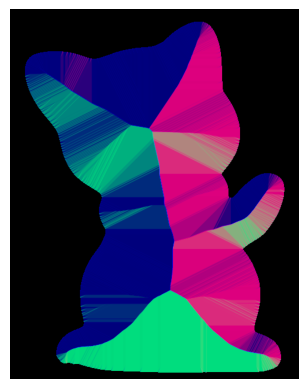

In [186]:
print(f'The Guide Normal:')

plt.imshow(get_guide_normal(average_image).clip(0,1))
# plt.title('Guide Normal')
plt.axis('off')

plt.savefig("../Report/IMG/res-02-guidenormal.png", bbox_inches="tight", pad_inches=0)

## Final output 

In [187]:
num_pixels = width * height
I = np.zeros((num_pixels, n_images))

for image_idx in range(n_images):
    p_index = 0
    for i in range(width):
        for j in range(height):
            I[p_index, image_idx] = shading_images[image_idx, i, j]
            p_index += 1

In [188]:
S = np.dot(I, np.linalg.pinv(L))

In [189]:
# replace nan values with 0
S = np.nan_to_num(S, nan=0.0)
S_r = S.reshape((width, height, 3))

In [190]:
# normalize S_r to get normal map
S_r_min = S_r.min(axis=(0,1), keepdims=True)
S_r_max = S_r.max(axis=(0,1), keepdims=True)
S_r_normalized = (S_r - S_r_min) / (S_r_max - S_r_min)

# reorder channels for visualization
S_r_normalized = S_r_normalized[:, :, [2, 1, 0]]  # from RGB to BGR

The normal map:


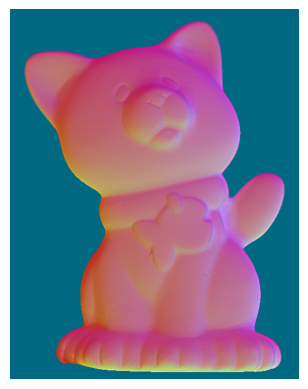

In [191]:
print(f'The normal map:')

plt.imshow(S_r_normalized)
# plt.title('Normal Map')
plt.axis('off')

plt.savefig("../Report/IMG/res-03-normalmap.png", bbox_inches="tight", pad_inches=0)

In [192]:
image_renderer(S_r, albedo_estimate)